# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# create an ordered dictionary
from collections import OrderedDict

# convert a string object to a list

from ast import literal_eval

# scale variables

from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# conduct PCA

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# conduct clustering

from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [43]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('There are ' + str(azdias.shape[0]) + ' rows in the azdias file.')

azdias.head()

There are 891221 rows in the azdias file.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [44]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [45]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [73]:
print('There are ' + str(feat_info.shape[0]) + ' rows in the feat_info file.')

feat_info

There are 85 rows in the feat_info file.


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

azdias_missing = azdias.isnull().sum()
azdias_missing

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [3]:
# fundction to replace missing/unknown values to Nan

def replace_missing(df1, df2):
    for i,j in enumerate(df1.columns):
        column_names = j
        
        for k in range(0, len(df2)):
            if column_names == df2.iloc[k][0]:
                m_object = df2.loc[df2.index[k], 'missing_or_unknown']
                if i < 57 or i >59:
                    m_list = literal_eval(m_object)
                    df1.iloc[:, i] = df1.iloc[:, i].apply(lambda x: np.nan if x in m_list else x)

                else:
                    m_list = m_object
                    df1.iloc[:, i] = df1.iloc[:, i].apply(lambda x: np.nan if (x == -1 or x == 'X' or x =='XX') else x)
    return df1

In [4]:
azdias2 = replace_missing(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# recheck the number of missing values
azdias_missing2 = azdias2.isnull().sum()

azdias_missing2

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [116]:
# Investigate patterns in the amount of missing data in each column.

# function to create a dictionary for the percentage of missing data for each column
def percent_missing(df):
    percent_dict = {}
    column_list = list(df.columns.values)
    percent_list = []
    
    missing_numbers = list(df.isnull().sum())
    for i in missing_numbers:
        percent = (i/len(df))*100
        percent_list.append(percent)
    
    percent_dict = dict(zip(column_list, percent_list))
    return percent_dict

In [35]:
# compare missing values before or after the conversion

percent_dict1 = percent_missing(azdias) # before
percent_dict2 = percent_missing(azdias2) # after

percent_dict_comb = pd.DataFrame([percent_dict1, percent_dict2]).T
percent_dict_comb.columns = ['percent_dict{}'.format(i) for i, col in enumerate(percent_dict_comb, 1)]

print(percent_dict_comb.to_string())

                       percent_dict1  percent_dict2
AGER_TYP                    0.000000      76.955435
ALTERSKATEGORIE_GROB        0.000000       0.323264
ALTER_HH                    8.247000      34.813699
ANREDE_KZ                   0.000000       0.000000
ANZ_HAUSHALTE_AKTIV        10.451729      11.176913
ANZ_HH_TITEL               10.884842      10.884842
ANZ_PERSONEN                8.247000       8.247000
ANZ_TITEL                   8.247000       8.247000
ARBEIT                     10.908181      10.926022
BALLRAUM                   10.518154      10.518154
CAMEO_DEUG_2015            11.106000      11.147852
CAMEO_DEU_2015             11.106000      11.147852
CAMEO_INTL_2015            11.106000      11.147852
CJT_GESAMTTYP               0.544646       0.544646
EWDICHTE                   10.518154      10.518154
FINANZTYP                   0.000000       0.000000
FINANZ_ANLEGER              0.000000       0.000000
FINANZ_HAUSBAUER            0.000000       0.000000
FINANZ_MINIM

In [95]:
# plot percentage of missing values in columns
def plot_percent_missing(df):
    percent_dict = percent_missing(df)
    percent_dict2 = dict(sorted(percent_dict.items(), key = lambda x: x[1]))
    
    keys = list(percent_dict2.keys())
    values = list(percent_dict2.values())

    df1 = pd.DataFrame({'Columns': keys, 'Percentages': values})
    
    df1.plot(y = 'Percentages', x = 'Columns', kind = 'bar', color = '#414ddb', figsize=(20, 5))
    plt.xlabel('Columns', fontsize = 15)
    plt.ylabel('Percentages (%)', fontsize = 15)
    plt.title('Distribution of Missing Values', fontsize = 15,  fontweight='bold') 
    plt.xticks(range(85), keys, fontsize = 10, rotation = 90)

    plt.show()

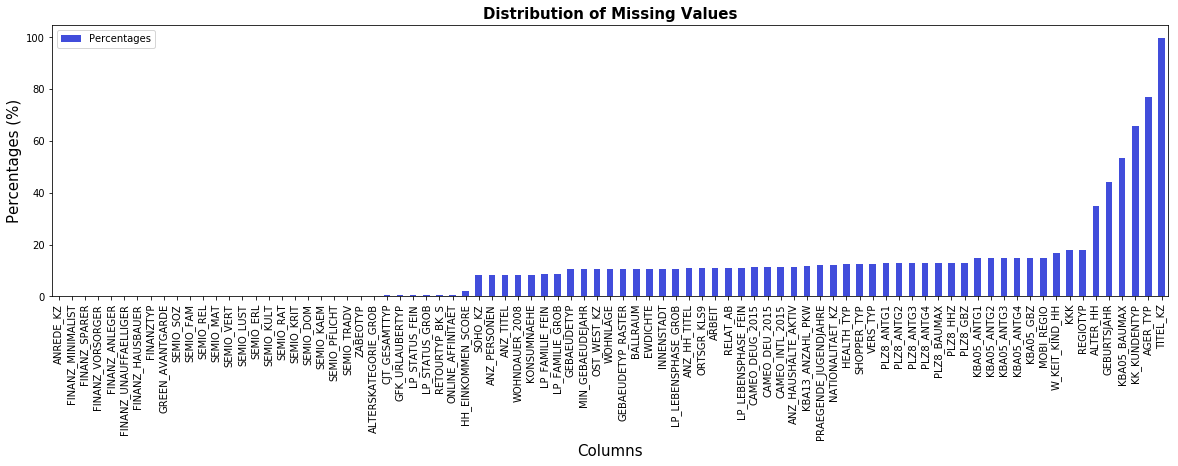

In [96]:
plot_percent_missing(azdias2)

In [5]:
# Find the name of columns with more than 20% missing values
outliers = [col for col in azdias2.columns if (azdias2[col].isnull().sum()/azdias2.shape[0]) * 100 > 20]
print(outliers)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [6]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias2 = azdias2.drop(['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis = 1)

In [77]:
azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The total sample size of the general population was 891,221. As shown in the comparison dataframe, the dataset before the missing value converstion included some naturally missing values (NaNs) ranging from 0% to 66%. After the conversion, the percentage of missing values in columns ranged from 0% to 99.7%. For example, AGER_TYP which had no NaNs ended up having more than three-quaters of its values missing after recoding all the unknown and missing values ("0"s and "1"s) into missing values. The columns that had no or very few values included life/SES status, personality, and household information. Those related to wealth/life stage and community charateristics information had 10% - 15% missing values.

From the bar plots, it was pretty clear that there were six columns that could be considered outliers. The columns for which more than 30% of observations are missing were: TITEL_KZ (Academic title flag), AGER_TYP (Best-ager typology), KK_KUNDENTYP (Consumer pattern over past 12 months), KBA05_BAUMAX (Most common building type within the microcell), GEBURTSJAHR (Year of birth), ALTER_HH (Birthdate of head of household). Nearly all people had the titles missing and three columns related to age and birth had a lot of values missing possibly because it may have not been easily available. KK_KUNDENTYP could be useful to identify consumer behavior based on prevous purchase history but the values were missing for two-thirds of the sample. These six outlier columns were removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?

# azdias = replace_missing(azdias, feat_info)
azdias.isnull().sum(axis=1)

0         49
1          4
2          4
3          9
4          3
5          2
6          5
7          4
8          4
9          3
10         3
11        53
12        10
13        11
14        53
15        11
16         9
17        53
18         9
19         5
20        16
21         6
22         6
23        11
24        53
25         9
26        24
27         5
28         4
29         4
          ..
891191     1
891192     4
891193     2
891194     2
891195     2
891196     2
891197     2
891198     4
891199     5
891200     5
891201     3
891202     5
891203    20
891204     2
891205     3
891206     3
891207     2
891208     6
891209     5
891210     4
891211     4
891212     4
891213     3
891214     4
891215     5
891216     6
891217     7
891218     9
891219     5
891220     6
Length: 891221, dtype: int64

In [8]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def assess_rows(df):
    # create a new column that has the count of non-Nan values
    df['non_nan_count'] = df.apply(lambda x: x.count(), axis=1)
    # subset it into two dataframes one for rows with no/little missing data (less than 10%) and one for the rest 
    df['subset'] = df['non_nan_count'].apply(lambda x: 1 if x > 76 else 0) 
    return df

In [13]:
azdias = assess_rows(azdias)

In [20]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,non_nan_count,subset
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,0
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,81,1
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,81,1
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,76,0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,82,1


In [18]:
# azdias = assess_rows(azdias)

# create two subsets
no_missing = azdias.loc[azdias['subset'] == 1]
missing = azdias.loc[azdias['subset'] == 0]

# percentage of people who has values for 90% values

percent_90 = (len(no_missing)/len(azdias))* 100
percent_90

79.12380879714459

In [19]:
azdias['subset'].value_counts()

1    705168
0    186053
Name: subset, dtype: int64

In [112]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_subsets(df1, df2, columns):
    for c in columns:
        fig, ax = plt.subplots(1,2)
        sns.countplot(no_missing[c], ax = ax[0])
        sns.countplot(missing[c], ax = ax[1])
        fig.subplots_adjust(wspace = 0.4)
        sns.set(rc={'figure.figsize':(10, 6)})
        fig.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


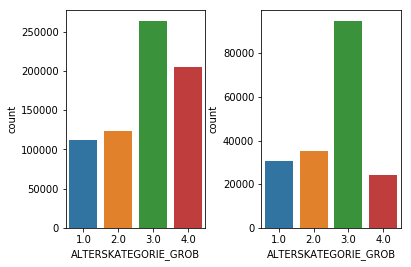

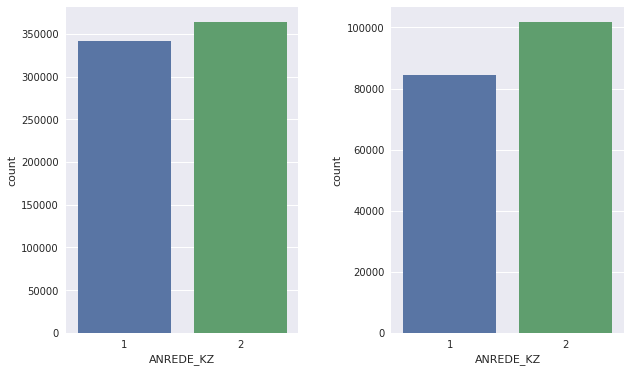

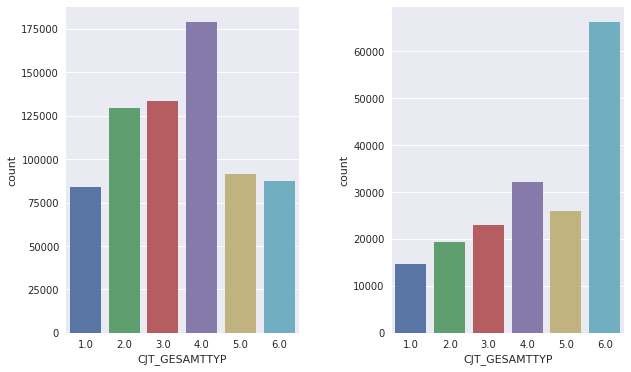

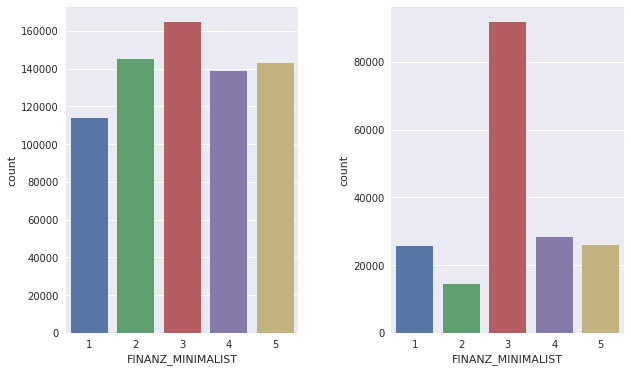

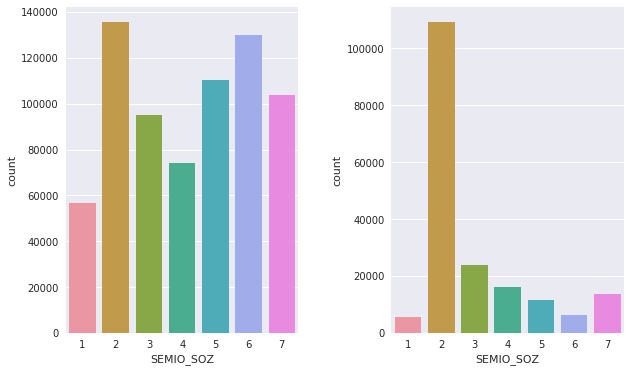

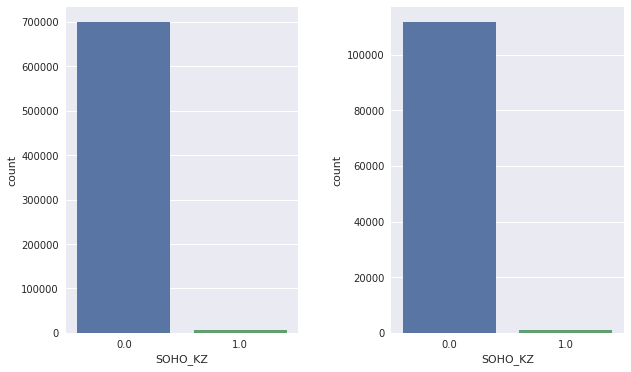

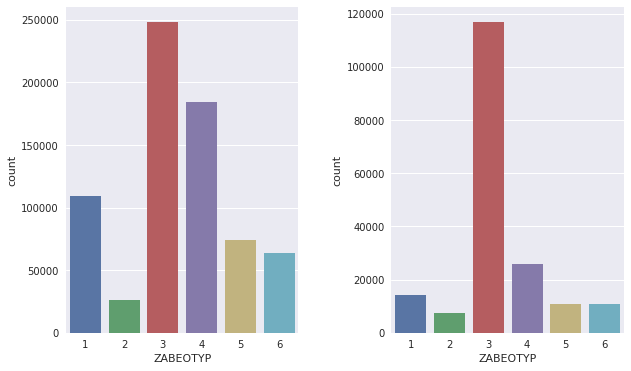

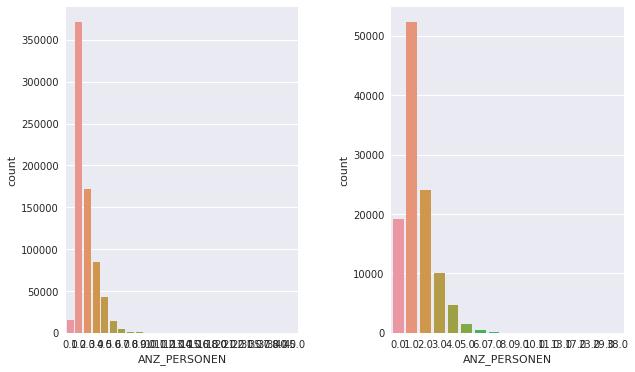

In [113]:
columns = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 
           'SEMIO_SOZ', 'SOHO_KZ','ZABEOTYP','ANZ_PERSONEN']

plot_subsets(no_missing, missing, columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

All people in the dataset had at least one missing value and about 12% of them had 10% or more missing values. When the distributions of values were compared between those who had very few missing values (no missing group, n = 70,5168) and those who had more than 10% of the values missing (missing group, n = 18,6053), the patterns were generally different. For example, the distributions of the 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', and 'SOHO_KZ' columns were somewhat similar between the no missing and missing groups but those for the 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'SEMIO_SOZ', 'ZABEOTYP', and 'ANZ_PERSONEN' were quite different in terms of the shape and dispersion of values. The results indicated that the missing group should be eliminated from the final sample, which was about 20% of the general population sample. The final proportion changed slightly due to additinoal removal of some columns before assessing missingness of the rows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [6]:
# How many features are there of each data type?

dropped = ['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
feat_info_final = feat_info[~ feat_info['attribute'].isin(dropped)]
feat_info_final['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [7]:
# Subset the data according to data types

categorical = feat_info_final.loc[feat_info_final['type'] == 'categorical']
mixed = feat_info_final.loc[feat_info_final['type'] == 'mixed']
ordinal = feat_info_final.loc[feat_info_final['type'] == 'ordinal']
numeric = feat_info_final.loc[feat_info_final['type'] == 'numeric']
interval = feat_info_final.loc[feat_info_final['type'] == 'interval']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [8]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def assess_variables(df1, df2):
    for row in df1['attribute']:
        print(df2[row].value_counts())

assess_variables(categorical, azdias)

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: FINANZTYP, dtype: int64
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     426379
10.0    137913
2.0     104305
0.0      72938
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    426379
5.0    200780
2.0    104305
0.0     72938
4.0     52784
3.0     29181
Name: LP_FAMILIE_GROB, dtype: int64
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0     

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


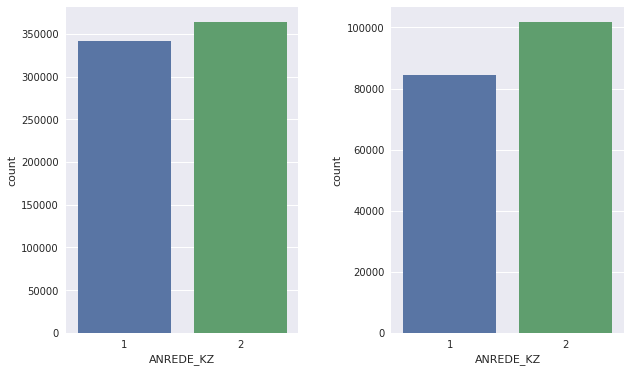

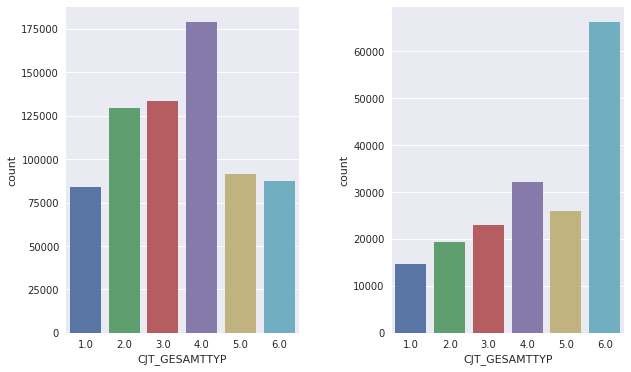

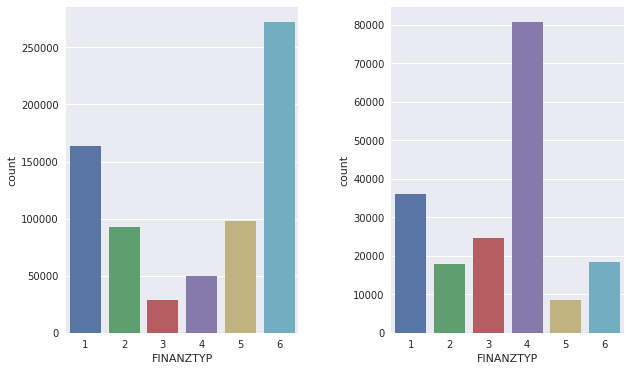

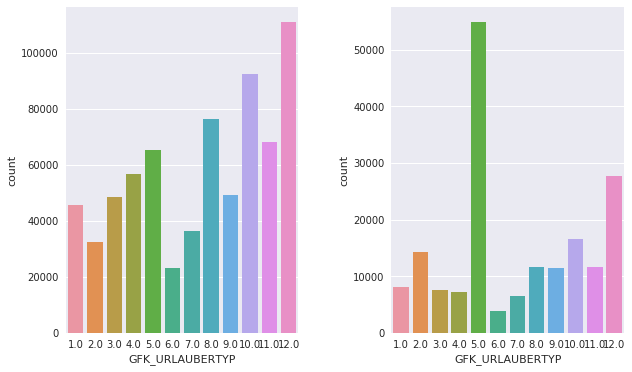

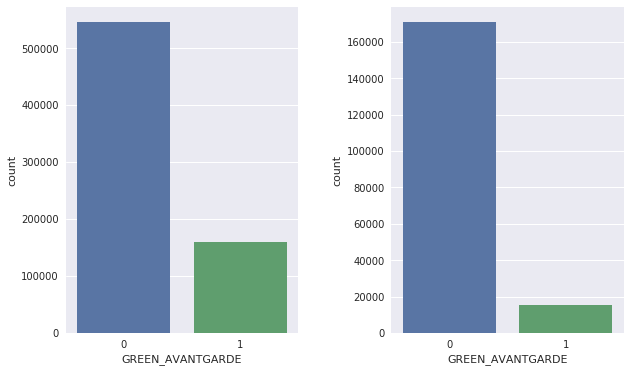

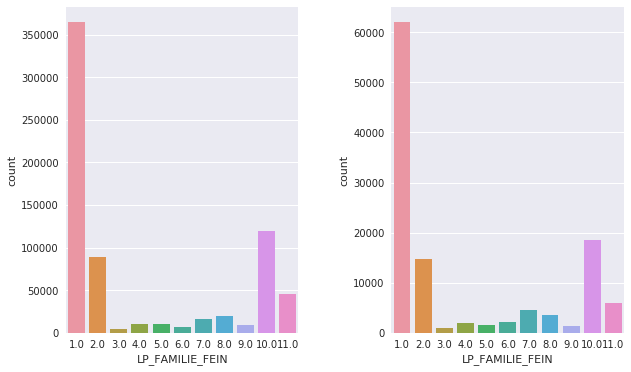

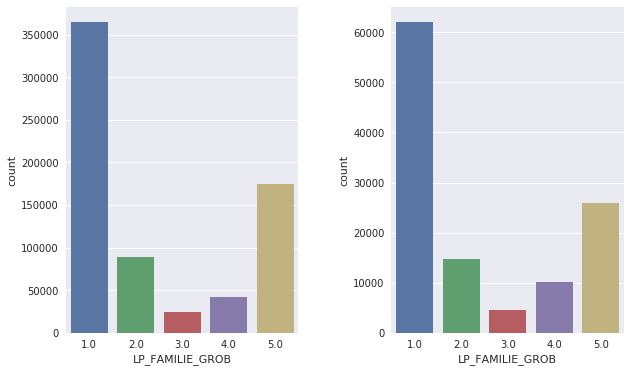

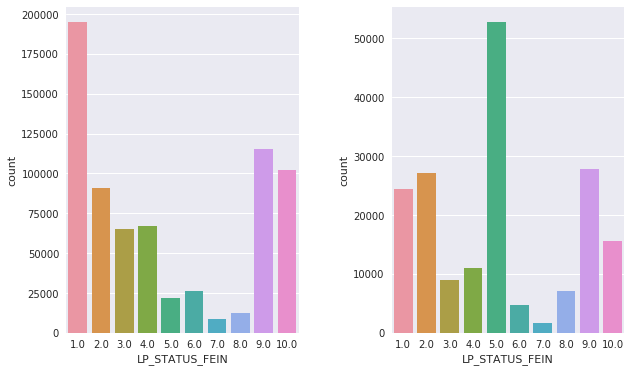

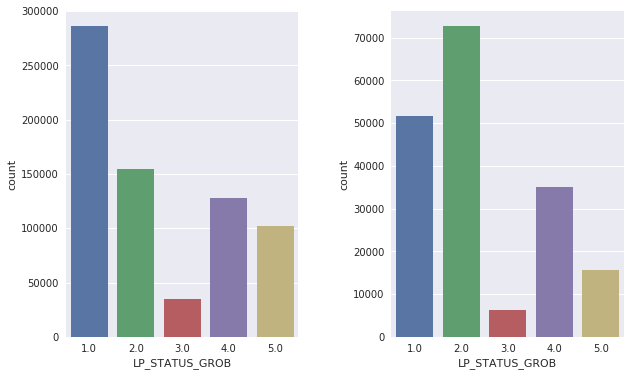

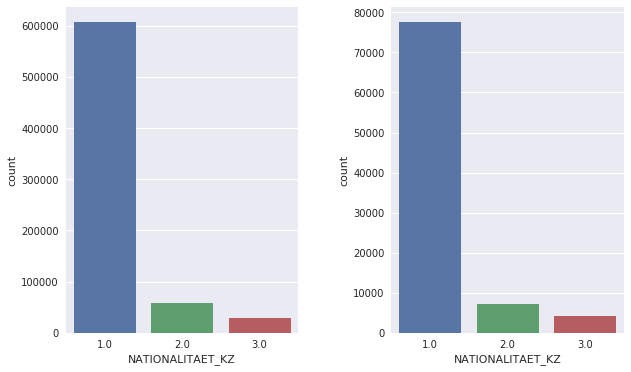

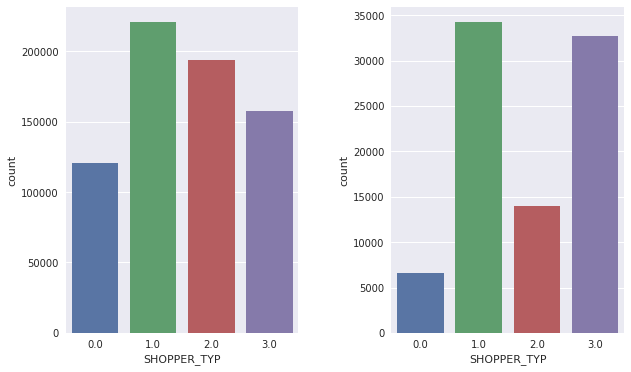

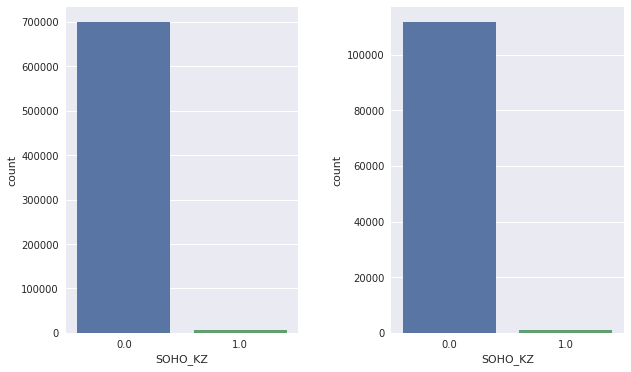

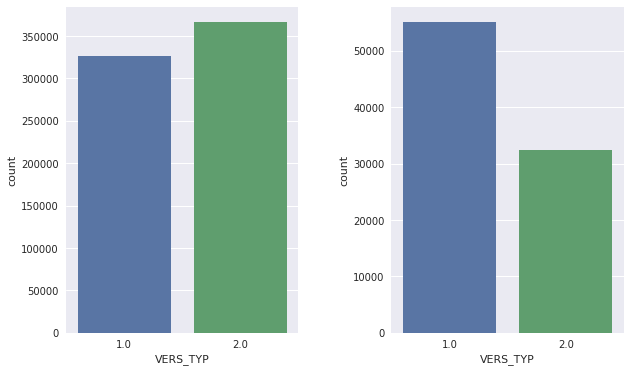

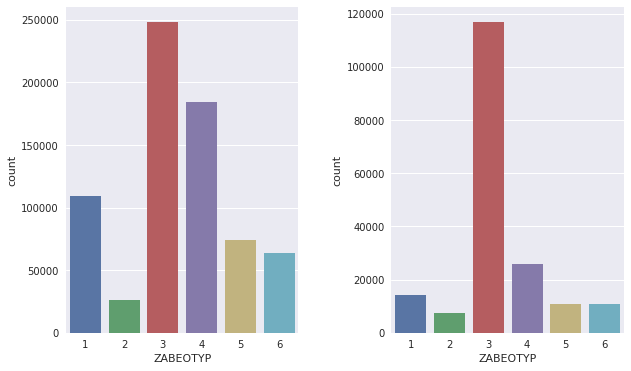

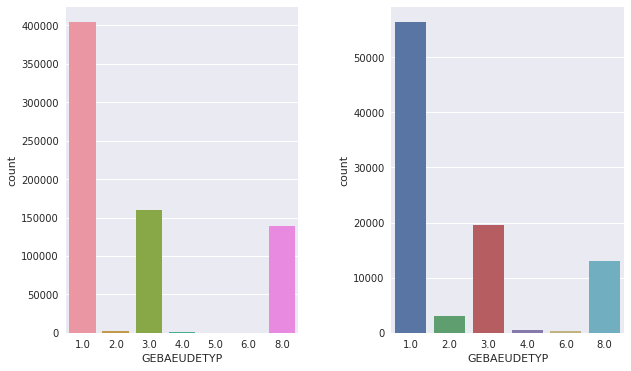

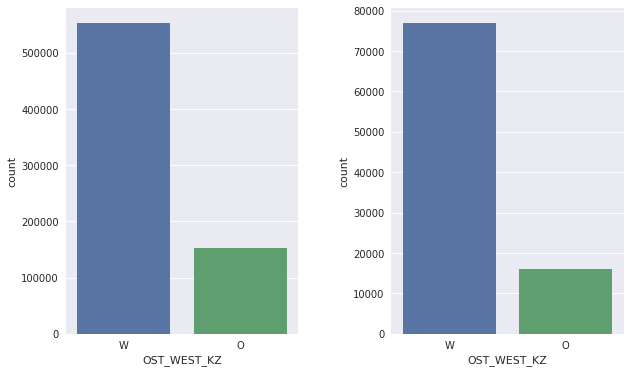

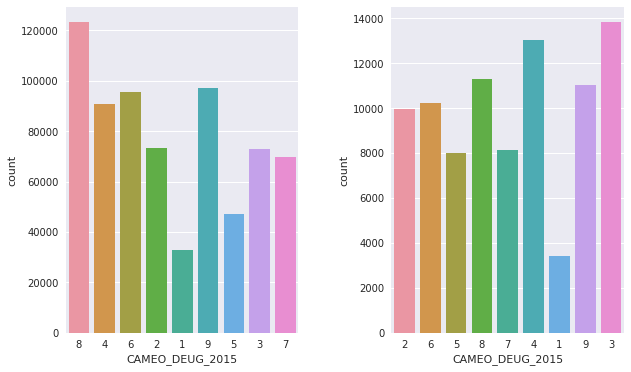

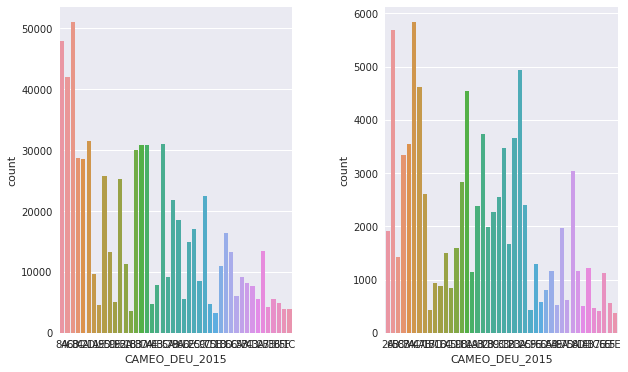

In [118]:
# categorical variables
columns2 = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 
           'LP_FAMILIE_GROB', 'LP_STATUS_FEIN','LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 
           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' ]

plot_subsets(no_missing, missing, columns2)

In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.

# function to recode variables
def recode_categorical(df, df2):
    # drop 'CAMEO_DEU_2015' which is similar to 'CAMEO_DEUG_2015' and CAMEO_INTL_2015' and has too many catgories
    df = df.drop(['CAMEO_DEU_2015'], axis = 1)
    
    # recode the binary 'OST_WEST_KZ' into a numeric variable - 1 = East, 0 = West
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else (0 if x == 'W' else x))
    
    # exclude the binary and the 'CAMEO_DEU_2015' variables plus those that are already deleted due to excessive missing values
    excluded_list = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

    categorical = df2.loc[df2['type'] == 'categorical']
    df_cat = categorical[~ categorical['attribute'].isin(excluded_list)]
    cat_list = list(df_cat['attribute'])

    # The other categorical variables are coded as dummy variables.
    df = pd.get_dummies(df, columns = cat_list)

    return df

In [12]:
azdias_recoded = recode_categorical(azdias, feat_info)

In [104]:
azdias_recoded.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_X
0,2.0,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,1,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,1,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,1,0,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There were five binary variables out of 18 categorical variables:'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', and 'OST_WEST_KZ.' These variables were kept. One of the binary variables, 'OST_WEST_KZ,' took non-numeric values and thus was treated as a categorical variable. It was recoded with a numeric scale.

Of multi-level categorical variables, 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', and 'SHOPPER_TYP' were retained because these were related to financial behavior and income levels. These were recoded as dummy variables. The remaimning 8 variables were dropped because they either consisted of too many categories or contained relatively less usful information such as biuilding types. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# movement: 1 = avantgarde
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
mainstream = [1, 3, 5, 8, 10, 12, 14]

# decades: [1,2]-40s, [3,4]-50s, [5,6,7]-60s, [8,9]-70s, [10, 11, 12, 13]-80s, [14,15]-90s
decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

# convert the movement part into a binary variable
azdias_recoded['PRAEGENDE_JUGENDJAHRE_avant'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE'].apply(lambda row: 1 if (row in avantgarde) else (0 if row in mainstream else row))

# convert the decades part into a ordinal variable
azdias_recoded['PRAEGENDE_JUGENDJAHRE_decades'] = azdias_recoded['PRAEGENDE_JUGENDJAHRE'].map(decades)

azdias_recoded[['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_avant', 'PRAEGENDE_JUGENDJAHRE_decades']].head()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades
0,NaN,NaN,NaN
1,14.0,0.0,6.0
2,15.0,1.0,6.0
3,8.0,0.0,4.0
4,8.0,0.0,4.0


In [16]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# make two new columns using string indexing

# wealth (1st digit): 1-wealthy, 2-prosperous, 3-comfortable, 4-less affluent, 5-poorer
azdias_recoded['CAMEO_INTL_2015_wealth'] = azdias_recoded['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)


# life stages (2nd digit): 
# 1-Pre-Family Couples & Singles
# 2-Young Couples With Children
# 3-Families With School Age Children
# 4-Wealthy Households - Older Families &  Mature Couples
# 5-Wealthy Households - Elders In Retirement
azdias_recoded['CAMEO_INTL_2015_life_stage'] = azdias_recoded['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else np.nan)
 
azdias_recoded[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage']].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,NaN,NaN,NaN
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


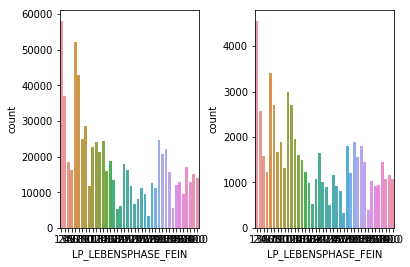

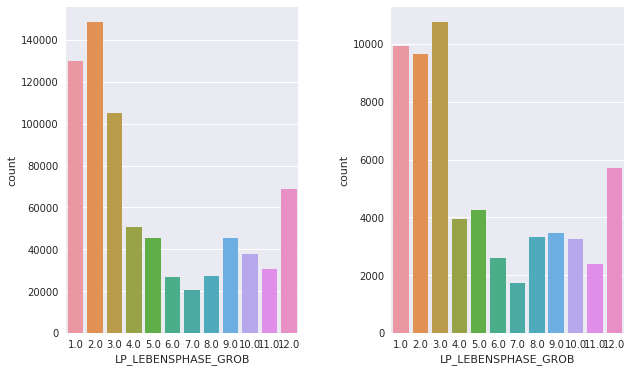

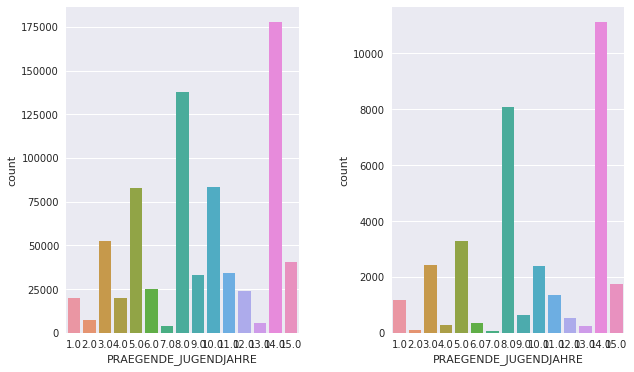

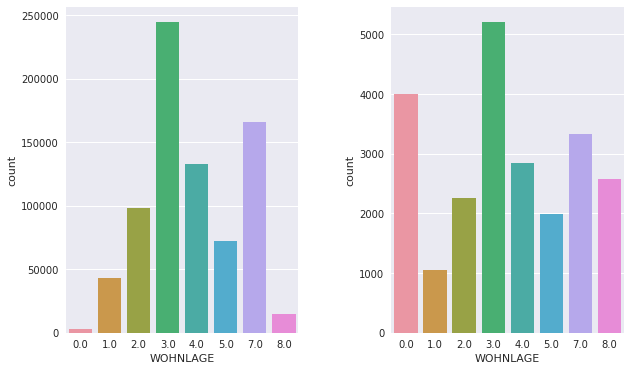

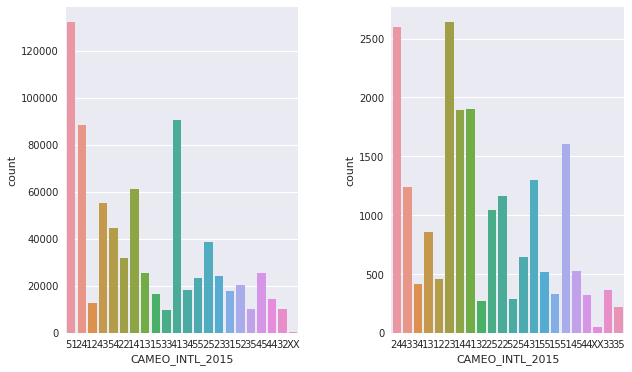

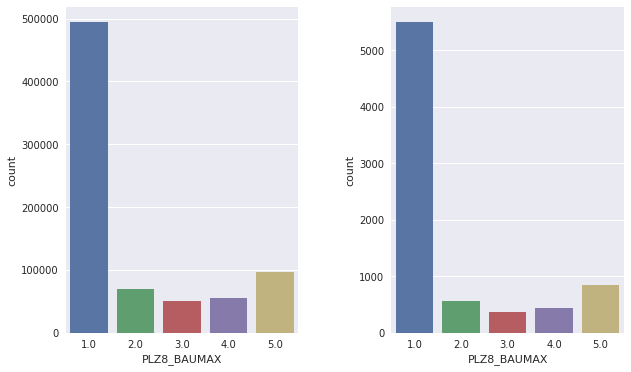

In [25]:
# mixed variables
columns3 = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE','CAMEO_INTL_2015', 'PLZ8_BAUMAX']

plot_subsets(no_missing, missing, columns3)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I kept the following mixed variables which could be highly related to purchasing behvior - 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. For the former, I created two lists, one for avantgarde and one for maistream and recoded it into two variables using the lists (movement and decades). For the latter, I split one variable of two digit value into two varibles of one digit value (wealth and life stages). 

I dropped the remaining four variables for the following reasons:

- LP_LEBENSPHASE_FEIN: too many categories, similar to cameo_intel.
- LP_LEBENSPHASE_GROB: similar to one dimension of the above.
- WOHNLAGE: neighborhood quality whose categories are too general.
- PLZ8_BAUMAX: building type in the plz8 region which is generally homogenous in values (mainly 1-2 family homes).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [71]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)




In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Some of the ordinal variables that ranged from hig to low need to be reverse coded so a higher number 
# indicates a higher value (e.g., finance). This will ensure that features that could be clustered change 
# in the same direction.


def reverse_code(df, gender, kkk, columns_5, columns_6, columns_7):
    
    # recode gender variable so male is 1 and female is 0 (currently, female is coded as 2). 
    # This makes female as a reference category.
    df[gender].replace(2,0, inplace=True)
    
    # for kkk

    df[kkk].replace([1,2,3,4], [4,3,2,1], inplace=True)
        
    # finanz variables
    for i in columns_5:
        df[i].replace([1,2,3,4,5], [5,4,3,2,1], inplace=True)
        
     # HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH
    for j in columns_6:
        df[j].replace([1,2,3,4,5,6], [6,5,4,3,2,1], inplace=True)
    
    # semio variables
    for k in columns_7:
        df[k].replace([1,2,3,4,5,6,7], [7,6,5,4,3,2,1], inplace=True)
    
    return df

In [14]:
gender = 'ANREDE_KZ'

kkk = 'KKK'

finanz_geb = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
        'FINANZ_HAUSBAUER', 'GEBAEUDETYP_RASTER']

semio = ['SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
        'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT', 'SEMIO_TRADV']

hh_mobi = ['HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'MOBI_REGIO']

azdias_recoded = reverse_code(azdias_recoded, gender, kkk, finanz_geb, semio, hh_mobi)

# 'REGIOTYP' is also removed. It is an ordinal variable but is more like a mixed variable with confusing categories.   
azdias_recoded = azdias_recoded.drop('REGIOTYP', axis = 1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [22]:
# function to return data with no or few missing data

def clean_data(df, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # replace missing values with NaNs
    for i,j in enumerate(df.columns):
        column_names = j
        
        for k in range(0, len(df2)):
            if column_names == df2.iloc[k][0]:
                m_object = df2.loc[df2.index[k], 'missing_or_unknown']
                if i < 57 or i >59:
                    m_list = literal_eval(m_object)
                    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: np.nan if x in m_list else x)

                else:
                    m_list = m_object
                    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: np.nan if (x == -1 or x == 'X' or x =='XX') else x)


    # assess missing values in each row and create two subsets
    df['non_nan_count'] = df.apply(lambda x: x.count(), axis=1)
    # subset it into two dataframes one for rows with no/little missing data (less than 10%) and one for the rest 
    df['subset'] = df['non_nan_count'].apply(lambda x: 1 if x > 76 else 0) 

    no_missing = df.loc[df['subset'] == 1]
    missing = df.loc[df['subset'] == 0]
    
    # select, re-encode, and engineer column values.
    # remove selected columns and rows, ...

    # remove columns that have too many missing or redundant information 
    columns_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'REGIOTYP', 
                       'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'ZABEOTYP', 'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    df = df.drop(columns_to_drop, axis = 1)

    # remove rows that have more than 10% of their values missing
    df = df.drop(df[df.subset == 0].index)
    
    # remove non_nan_count and subset columns
    df = df.drop(['non_nan_count', 'subset'], axis = 1)

    # recode categorical variables
    
    # recode the binary 'OST_WEST_KZ' into a numeric variable - 1 = East, 0 = West
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else (0 if x == 'W' else x))
    
    # exclude the binary variables plus those that are already deleted due to excessive missing values
    excluded_list = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', 'GFK_URLAUBERTYP', 
                     'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ','ZABEOTYP', 
                     'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

    categorical = df2.loc[df2['type'] == 'categorical']
    df_cat = categorical[~ categorical['attribute'].isin(excluded_list)]
    cat_list = list(df_cat['attribute'])

    # The other categorical variables are coded as dummy variables.
    df = pd.get_dummies(df, columns = cat_list)

    # recode the"PRAEGENDE_JUGENDJAHRE" into the two new variables.
    # movement: 1 = avantgarde, 0 = mainstream
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    # decades: [1,2]-40s, [3,4]-50s, [5,6,7]-60s, [8,9]-70s, [10, 11, 12, 13]-80s, [14,15]-90s
    decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    # convert the movement part into a binary variable
    df['PRAEGENDE_JUGENDJAHRE_avant'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda row: 1 if (row in avantgarde) else (0 if row in mainstream else row))

    # convert the decades part into a ordinal variable
    df['PRAEGENDE_JUGENDJAHRE_decades'] = df['PRAEGENDE_JUGENDJAHRE'].map(decades)

    # recode the "CAMEO_INTL_2015" variable into the two new variables.

    # wealth (1st digit): 1-wealthy, 2-prosperous, 3-comfortable, 4-less affluent, 5-poorer
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

    # life stages (2nd digit): 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else np.nan)

    df = df.drop(['CAMEO_INTL_2015_wealth', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
    # reverse code gender and ordinal variables
    
    gender = 'ANREDE_KZ'
    
    kkk = 'KKK'
    
    finanz_geb = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
            'FINANZ_HAUSBAUER', 'GEBAEUDETYP_RASTER']

    semio = ['SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
            'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT', 'SEMIO_TRADV']

    hh_mobi = ['HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'MOBI_REGIO']

    # recode gender variable so male is 1 and female is 0 (currently, female is coded as 2). 
    # This makes female as a reference category.
    df[gender].replace(2,0, inplace = True)
    
    # for kkk
    df[kkk].replace([1,2,3,4], [4,3,2,1], inplace = True)
        
    # finanz variables
    for i in finanz_geb:
        df[i].replace([1,2,3,4,5], [5,4,3,2,1], inplace = True)
        
     # HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH
    for j in semio:
        df[j].replace([1,2,3,4,5,6], [6,5,4,3,2,1], inplace = True)
    
    # semio variables
    for k in hh_mobi:
        df[k].replace([1,2,3,4,5,6,7], [7,6,5,4,3,2,1], inplace = True)
    
    # Return the cleaned dataframe.

    return df

In [31]:
# function to return data with no or few missing data - to be added as a cluster later 

def clean_data_missing(df, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    # replace missing values with NaNs
    for i,j in enumerate(df.columns):
        column_names = j
        
        for k in range(0, len(df2)):
            if column_names == df2.iloc[k][0]:
                m_object = df2.loc[df2.index[k], 'missing_or_unknown']
                if i < 57 or i >59:
                    m_list = literal_eval(m_object)
                    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: np.nan if x in m_list else x)

                else:
                    m_list = m_object
                    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: np.nan if (x == -1 or x == 'X' or x =='XX') else x)


    # assess missing values in each row and create two subsets
    df['non_nan_count'] = df.apply(lambda x: x.count(), axis=1)
    # subset it into two dataframes one for rows with no/little missing data (less than 10%) and one for the rest 
    df['subset'] = df['non_nan_count'].apply(lambda x: 1 if x > 76 else 0) 

    no_missing = df.loc[df['subset'] == 1]
    missing = df.loc[df['subset'] == 0]
    
    # select, re-encode, and engineer column values.
    # remove selected columns and rows, ...

    # remove columns that have too many missing or redundant information 
    columns_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 
                       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'REGIOTYP', 
                       'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'ZABEOTYP', 'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    df = df.drop(columns_to_drop, axis = 1)

    # retain the rows that have more than 10% of their values missing
    df = df.drop(df[df.subset == 1].index)
    
    # remove non_nan_count and subset columns
    df = df.drop(['non_nan_count', 'subset'], axis = 1)

    # recode categorical variables
    
    # recode the binary 'OST_WEST_KZ' into a numeric variable - 1 = East, 0 = West
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else (0 if x == 'W' else x))
    
    # exclude the binary variables plus those that are already deleted due to excessive missing values
    excluded_list = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', 'GFK_URLAUBERTYP', 
                     'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ','ZABEOTYP', 
                     'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

    categorical = df2.loc[df2['type'] == 'categorical']
    df_cat = categorical[~ categorical['attribute'].isin(excluded_list)]
    cat_list = list(df_cat['attribute'])

    # The other categorical variables are coded as dummy variables.
    df = pd.get_dummies(df, columns = cat_list)

    # recode the"PRAEGENDE_JUGENDJAHRE" into the two new variables.
    # movement: 1 = avantgarde, 0 = mainstream
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    # decades: [1,2]-40s, [3,4]-50s, [5,6,7]-60s, [8,9]-70s, [10, 11, 12, 13]-80s, [14,15]-90s
    decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    # convert the movement part into a binary variable
    df['PRAEGENDE_JUGENDJAHRE_avant'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda row: 1 if (row in avantgarde) else (0 if row in mainstream else row))

    # convert the decades part into a ordinal variable
    df['PRAEGENDE_JUGENDJAHRE_decades'] = df['PRAEGENDE_JUGENDJAHRE'].map(decades)

    # recode the "CAMEO_INTL_2015" variable into the two new variables.

    # wealth (1st digit): 1-wealthy, 2-prosperous, 3-comfortable, 4-less affluent, 5-poorer
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

    # life stages (2nd digit): 
    df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else np.nan)

    df = df.drop(['CAMEO_INTL_2015_wealth', 'PRAEGENDE_JUGENDJAHRE'], axis = 1)
    # reverse code gender and ordinal variables
    
    gender = 'ANREDE_KZ'
    
    kkk = 'KKK'
    
    finanz_geb = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
            'FINANZ_HAUSBAUER', 'GEBAEUDETYP_RASTER']

    semio = ['SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
            'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT', 'SEMIO_TRADV']

    hh_mobi = ['HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'MOBI_REGIO']

    # recode gender variable so male is 1 and female is 0 (currently, female is coded as 2). 
    # This makes female as a reference category.
    df[gender].replace(2,0, inplace = True)
    
    # for kkk
    df[kkk].replace([1,2,3,4], [4,3,2,1], inplace = True)
        
    # finanz variables
    for i in finanz_geb:
        df[i].replace([1,2,3,4,5], [5,4,3,2,1], inplace = True)
        
     # HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH
    for j in semio:
        df[j].replace([1,2,3,4,5,6], [6,5,4,3,2,1], inplace = True)
    
    # semio variables
    for k in hh_mobi:
        df[k].replace([1,2,3,4,5,6,7], [7,6,5,4,3,2,1], inplace = True)
    
    # Return the cleaned dataframe.

    return df

In [83]:
azdias_cleaned = clean_data(azdias, feat_info) # for non-missing data
azdias_cleaned_missing = clean_data_missing(azdias, feat_info) # for missing data

In [33]:
print(azdias_cleaned.shape, azdias_cleaned_missing.shape ) 

(732124, 84) (159097, 84)


In [85]:
# save the cleaned data to use it later
azdias_cleaned.to_csv('azdias_cleaned.csv', sep = ';', index = False)
azdias_cleaned_missing.to_csv('azdias_cleaned_missing.csv', sep = ';', index = False)

In [34]:
azdias_cleaned_missing.to_csv('azdias_cleaned_missing.csv', sep = ';', index = False)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_cleaned = pd.read_csv('azdias_cleaned.csv', delimiter = ';')
azdias_cleaned_missing = pd.read_csv('azdias_cleaned_missing.csv', delimiter = ';')

# replace missing values with a mode in each column
azdias_imputed = azdias_cleaned.fillna(azdias_cleaned.mode().iloc[0])
azdias_imputed_missing = azdias_cleaned_missing.fillna(azdias_cleaned_missing.mode().iloc[0])

In [24]:
# Apply feature scaling to the general population demographics data.

def scale_variables(df):
    scaler = preprocessing.StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns = df.columns)
    return df_scaled

In [26]:
azdias_scaled = scale_variables(azdias_imputed)

azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,-1.745331,-0.967143,1.523882,-1.583638,1.052322,-1.515463,-1.033712,-1.341487,-0.540443,1.022496,...,5.260360,-0.255083,-0.567459,-0.450691,-0.674970,-0.610610,1.861250,-0.540443,1.136311,-1.253076
1,0.199519,-0.967143,1.523882,-0.904906,1.773429,0.542974,-0.307958,-1.341487,1.850334,1.022496,...,-0.190101,-0.255083,-0.567459,-0.450691,-0.674970,1.637708,-0.537273,1.850334,1.136311,0.756387
2,1.171944,-0.967143,-0.676124,0.452556,-1.110999,0.542974,1.143550,0.826192,-0.540443,-0.300183,...,-0.190101,-0.255083,-0.567459,-0.450691,1.481548,-0.610610,-0.537273,-0.540443,-0.228530,-0.583255
3,0.199519,1.033973,-0.676124,-0.226175,-0.389892,1.229119,-0.307958,0.826192,-0.540443,1.022496,...,-0.190101,-0.255083,1.762240,-0.450691,-0.674970,1.637708,-0.537273,-0.540443,-0.228530,0.086566
4,-1.745331,-0.967143,0.057211,1.131288,-1.110999,0.542974,0.417796,-1.341487,-0.540443,1.022496,...,-0.190101,-0.255083,-0.567459,2.218815,-0.674970,-0.610610,-0.537273,-0.540443,-1.593372,0.756387


In [36]:
azdias_scaled_missing = scale_variables(azdias_imputed_missing)

azdias_scaled_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,-0.660099,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,0.017965,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
1,-0.660099,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,0.017965,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
2,-1.781651,-0.910122,1.864546,-0.394190,0.144091,-0.631944,-0.647779,0.661183,3.918917,2.199790,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,2.251069,3.918917,0.490603,1.028782
3,0.461452,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,0.017965,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
4,1.583004,-0.910122,-0.852817,2.127028,-2.018699,2.331119,2.796787,-1.076929,-0.255173,0.017965,...,-0.153148,-0.230962,-0.40535,-0.16014,2.282887,-0.239474,-0.444233,-0.255173,-2.218459,-0.570969


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Since the majority of people had missing data, eliminating all records that had missing data was not a good idea. Thus, I decided to replace the missing values with a "mode" which is the most frequent value in each column. Since there were only a few numeric variable, using a "mode" instead of a "mean" made more sense. To normalize the values, I used sklearn's StandardScaler function.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.

def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [6]:
# use 9 since there are 9 big catgories of features in the dataset

pca, azdias_pca = do_pca(9, azdias_scaled)

In [7]:
def pca_results(df, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 1), columns = df.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
Dimension 1,0.1297,-0.1,-0.0,0.2,-0.1,0.1,-0.0,-0.0,-0.2,-0.1,...,0.0,-0.0,-0.1,-0.0,-0.0,0.0,-0.0,-0.1,0.1,-0.1
Dimension 2,0.0887,0.3,0.0,-0.2,0.3,-0.3,0.3,0.3,-0.1,0.0,...,-0.1,-0.1,-0.0,-0.0,-0.0,-0.0,0.1,0.0,-0.3,0.0
Dimension 3,0.0457,-0.0,0.1,-0.1,0.0,-0.0,0.2,-0.1,0.1,0.3,...,-0.0,0.1,0.1,0.0,-0.0,-0.0,0.0,0.3,0.0,0.0
Dimension 4,0.0375,-0.0,-0.1,0.1,0.0,-0.0,0.0,-0.1,-0.2,0.1,...,-0.0,-0.1,-0.0,0.1,0.0,-0.2,0.2,0.1,-0.1,0.1
Dimension 5,0.0333,0.1,-0.2,0.0,0.0,-0.0,-0.1,0.1,-0.1,0.0,...,0.1,0.1,0.3,-0.0,-0.1,0.0,0.2,0.0,-0.0,0.0
Dimension 6,0.0299,-0.1,0.3,-0.1,-0.0,0.1,0.0,0.1,0.1,-0.0,...,-0.1,0.0,0.0,0.2,0.2,-0.2,-0.1,-0.0,0.0,-0.0
Dimension 7,0.0267,-0.0,0.2,0.0,-0.0,-0.1,-0.0,-0.0,-0.1,-0.1,...,0.0,0.1,0.2,0.2,0.0,-0.2,-0.1,-0.1,0.0,-0.0
Dimension 8,0.0260,0.0,-0.1,-0.0,0.1,-0.0,0.0,0.1,0.1,-0.0,...,0.0,0.0,0.0,-0.2,0.1,0.0,0.1,-0.0,-0.0,0.0
Dimension 9,0.0239,0.0,-0.1,0.0,-0.1,0.1,-0.0,-0.1,0.0,0.1,...,-0.0,-0.0,-0.1,-0.2,0.1,-0.1,0.1,0.1,0.1,0.0


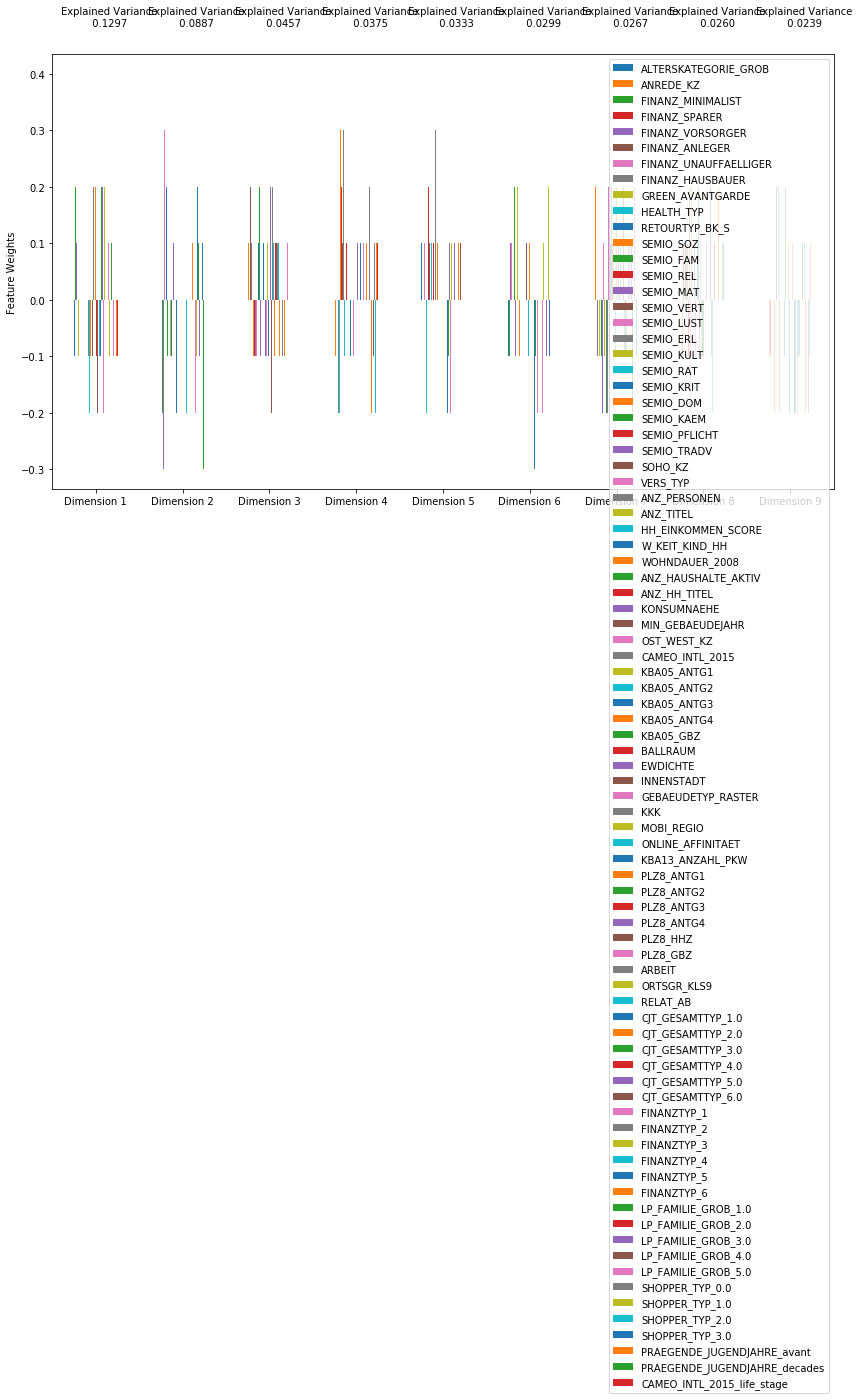

In [8]:
pca_results(azdias_scaled, pca)

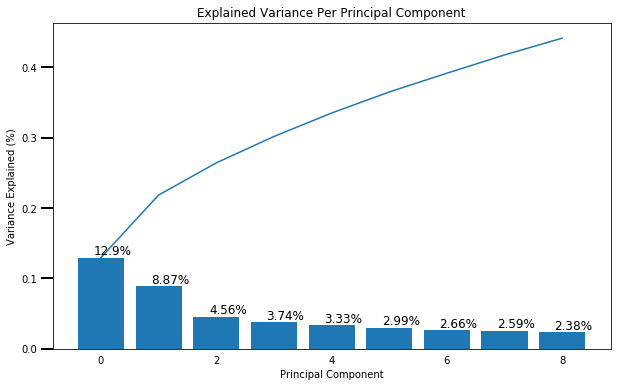

In [90]:
def scree_plot(pca):
    
    # creates a scree plot associated with the principal components 
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [29]:
def num_comps(num_comps, df):
    for comp in range(num_comps, df.shape[1]):
        pca, X_pca = do_pca(comp, df)
        
        variance = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_sum = np.sum(variance)
        print(variance_sum)
        if variance_sum >= .50:
            print('{} are needed to achive {} of the original variances explained'.format(comp,variance_sum ))
            break        

In [30]:
num_comps(10, azdias_scaled)

0.462300693343
0.481195208049
0.500107206478
12 are needed to achive 0.5001072064781876 of the original variances explained


In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, azdias_pca = do_pca(12, azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

The first principal component explained 13% of the varinace, followed by 9% and 4.5% explained by the second and third componets. The amount of variance explained by the first few components were not big and this made me struggle to select the right number of components. I initally selected 41 components that captured 85% total variance. It was on the high end and thus decided to select 12 components. I know there is no magic threshold but wanted to capture at least 50% of the total variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [74]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# def map_weights(pca):
 
def map_weights(df, pca, comp_num):
    weight_map = {}
    for i, val in enumerate(df.columns):
        weight_map[val] = pca.components_[comp_num][i]
        weights_sorted = sorted(weight_map.items(), key = lambda kv: kv[1], reverse = True)
    return weights_sorted

In [12]:
# first pricipal component and linked values

map_weights(azdias_scaled, pca, 1)

[('FINANZ_SPARER', 0.31298773864616913),
 ('FINANZ_ANLEGER', 0.28968795342103904),
 ('FINANZ_UNAUFFAELLIGER', 0.28781595519959208),
 ('ALTERSKATEGORIE_GROB', 0.28020036729601916),
 ('RETOURTYP_BK_S', 0.2163970575381754),
 ('FINANZTYP_5', 0.15185469114968339),
 ('CJT_GESAMTTYP_2.0', 0.13800160799618713),
 ('FINANZTYP_2', 0.1209840801916777),
 ('SEMIO_TRADV', 0.12027161857208589),
 ('SEMIO_ERL', 0.10323529045919208),
 ('CJT_GESAMTTYP_1.0', 0.09765477632132448),
 ('WOHNDAUER_2008', 0.087258144020909895),
 ('FINANZTYP_6', 0.084277608423787842),
 ('SHOPPER_TYP_3.0', 0.075527987074918645),
 ('SEMIO_RAT', 0.066178832954127201),
 ('SEMIO_PFLICHT', 0.062055260112622593),
 ('LP_FAMILIE_GROB_2.0', 0.056845409520602713),
 ('LP_FAMILIE_GROB_1.0', 0.051655813619987681),
 ('EWDICHTE', 0.049361106285769125),
 ('ORTSGR_KLS9', 0.047943018573373096),
 ('PLZ8_ANTG3', 0.044977549719033262),
 ('PLZ8_ANTG4', 0.04379482271699555),
 ('SEMIO_LUST', 0.041373584222610858),
 ('KBA05_ANTG4', 0.039019844295012526),


In [97]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(azdias_scaled, pca, 2)

[('PRAEGENDE_JUGENDJAHRE_avant', 0.33713377982645876),
 ('GREEN_AVANTGARDE', 0.33713377982645859),
 ('EWDICHTE', 0.24902644657431394),
 ('ORTSGR_KLS9', 0.23514346102167233),
 ('HH_EINKOMMEN_SCORE', 0.21965939086843889),
 ('KKK', 0.2009761191178952),
 ('FINANZTYP_5', 0.18196418573406367),
 ('SEMIO_KAEM', 0.17237144462324452),
 ('ANZ_PERSONEN', 0.15716806958064514),
 ('FINANZ_ANLEGER', 0.15663994055636382),
 ('FINANZ_HAUSBAUER', 0.14939098622272115),
 ('ONLINE_AFFINITAET', 0.1477012188769031),
 ('LP_FAMILIE_GROB_5.0', 0.12268071171832352),
 ('ANREDE_KZ', 0.12255937782774273),
 ('W_KEIT_KIND_HH', 0.12138488513233871),
 ('PLZ8_ANTG2', 0.10777029986516451),
 ('PLZ8_ANTG3', 0.10247786306524849),
 ('RELAT_AB', 0.10145264481372872),
 ('PLZ8_HHZ', 0.099861806323561522),
 ('SEMIO_DOM', 0.090727408734507561),
 ('SEMIO_KRIT', 0.084962750935552209),
 ('PLZ8_ANTG4', 0.084481971228509992),
 ('FINANZTYP_3', 0.078934078157568949),
 ('GEBAEUDETYP_RASTER', 0.075988160038316918),
 ('LP_FAMILIE_GROB_4.0', 

In [17]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(azdias_scaled, pca, 3)

[('SEMIO_KULT', 0.38842327579727609),
 ('SEMIO_FAM', 0.3400883398246129),
 ('SEMIO_ERL', 0.30851853501005144),
 ('SEMIO_SOZ', 0.25531435271776215),
 ('SEMIO_REL', 0.22103807578957591),
 ('SEMIO_LUST', 0.2076326327740613),
 ('SHOPPER_TYP_3.0', 0.16090786976447596),
 ('FINANZTYP_2', 0.15460479834335658),
 ('GREEN_AVANTGARDE', 0.13487731203972347),
 ('PRAEGENDE_JUGENDJAHRE_avant', 0.13487731203972347),
 ('SEMIO_PFLICHT', 0.11274275913188252),
 ('KKK', 0.10974154772999253),
 ('SEMIO_KRIT', 0.098808874213407588),
 ('CJT_GESAMTTYP_2.0', 0.097055649860023366),
 ('FINANZTYP_1', 0.090586564241696407),
 ('PLZ8_HHZ', 0.081355377092378556),
 ('SEMIO_VERT', 0.077631160074912955),
 ('FINANZ_MINIMALIST', 0.075839181976600001),
 ('CAMEO_INTL_2015_life_stage', 0.071229293241567376),
 ('KBA13_ANZAHL_PKW', 0.069756728627949696),
 ('PLZ8_GBZ', 0.064444734564754566),
 ('HH_EINKOMMEN_SCORE', 0.057191998200429424),
 ('EWDICHTE', 0.052830292265066116),
 ('SHOPPER_TYP_0.0', 0.051817574952453239),
 ('ORTSGR_KLS

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In order to identify the themes that could categorize each pricipal component, I looked at the top 5 and bottom 5 variables that were associated with each component. The first component was generally associated wtih people's financial and purchase behaviors. People who were older and had a tendency of saving and investing money were likely to be grouped togehter on this dimension. They were contrasted with people who were minimalist and younger. This indicated that positive and negative values from the components could be interpreted in a meaningful way. 

The second component captured variables around geographical and household information such as distance to city and household density. People live in more urban densley-populated locations earing higher income scored high on this dimension. They were also more likely to have avantgarde tendency as youth.  

The third component was more related to personality indicators. People who were family oriented, religious, and culturally-mided would show similar behavior on this dimension while those who were combative or shopping stressed would exhibit different trends. 

As shown in my interpretations, the positive and negative values were meaningful in showing what features were more liekly to occur or not occur together. The information on different dimensions can be used to create different marketing strategies to target different segments of consumers.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [19]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):

    #instantiate kmeans
    kmeans = KMeans(n_clusters = center)

    # Then fitthe model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

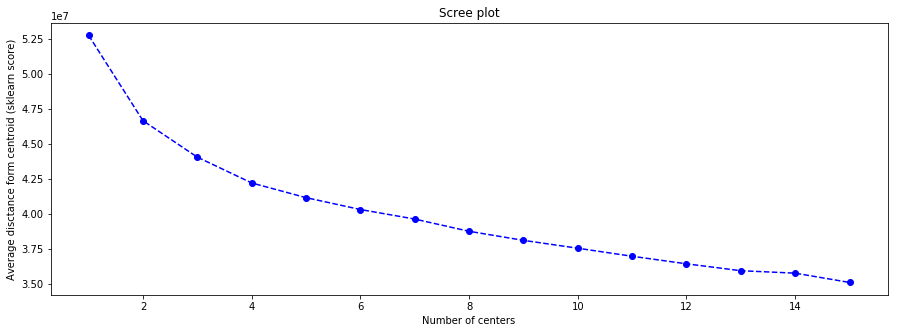

In [22]:
# Plot distances and number of clusters

scores = []
centers = list(range(1,16))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))
    
plt.plot(centers, scores, linestyle = '--', marker = 'o', color = 'b')
plt.title('Scree plot')
plt.xlabel('Number of centers');
plt.ylabel('Average disctance form centroid (sklearn score)')
plt.rcParams["figure.figsize"] = [15, 5]

In [42]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 12) 
general_model = kmeans.fit(azdias_pca)
general_predicted = general_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Due to the length of time to cluster component counts as well as the issue with the internet conncetivity, I wasn't able to test for more than 25 components. However, I could still see that the slope of the plot started leveling off at about 10 components. These components explained a little under 50% of the total variance. Unlike other scree plots, it was not very clear where the elbow is. I chose 12 components to cluster the data, which accounted for 50% of the total variance after which an additinonal component added little value in terms of accounting for additional variances.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [91]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [30]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,non_nan_count,subset
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,83,1
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,0
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,82,1
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,77,1
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,84,1


In [92]:
# preprocess customers data for the no missing group
customers_cleaned = clean_data(customers, feat_info)
customers_imputed = customers_cleaned.fillna(customers_cleaned.mode().iloc[0])   
customers_scaled = scale_variables(customers_imputed)

# transform the customers data using the general population pca 
customers_pca = pca.transform(customers_scaled)

# predict customers data clustering using the general population kmeans model 
customers_predicted = general_model.predict(customers_pca)

In [93]:
# preprocess customers data for the missing group
customers_cleaned_missing = clean_data_missing(customers, feat_info)
customers_imputed_missing = customers_cleaned_missing.fillna(customers_cleaned_missing.mode().iloc[0])   
customers_scaled_missing = scale_variables(customers_imputed_missing)

In [94]:
customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,0.694582,0.699692,-0.717629,0.501186,-0.499109,0.590449,-0.210551,0.584905,0.974525,-1.273441,...,-0.101607,-0.235139,-0.869077,-0.536744,-0.585325,-0.447377,1.385177,0.969037,-0.642505,-0.283602
1,0.694582,-1.429201,-0.717629,0.501186,-0.499109,0.590449,-2.352421,-0.945130,0.974525,0.030563,...,-0.101607,-0.235139,-0.869077,-0.536744,1.708453,-0.447377,-0.721929,0.969037,-0.642505,0.463519
2,-0.707588,0.699692,1.264020,0.501186,0.716247,-2.470376,-3.423356,0.584905,-1.026141,1.334566,...,-0.101607,-0.235139,1.150646,-0.536744,1.708453,-0.447377,-0.721929,-1.031953,0.864963,-1.777844
3,-0.707588,0.699692,-0.717629,0.501186,-0.499109,0.590449,-0.210551,-0.180113,0.974525,1.334566,...,-0.101607,-0.235139,-0.869077,-0.536744,1.708453,-0.447377,-0.721929,0.969037,-0.642505,0.463519
4,0.694582,0.699692,-0.717629,0.501186,-0.499109,0.590449,0.860384,0.584905,0.974525,0.030563,...,-0.101607,-0.235139,-0.869077,1.863087,-0.585325,-0.447377,-0.721929,0.969037,-0.642505,-0.283602


In [95]:
customers_scaled_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,1.875042,0.966910,-2.473917,2.377442,-2.404106,2.480102,1.363762,1.290354,-0.228967,-0.333075,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,3.212964,-0.228967,0.208652,0.192283
1,0.912957,-1.034223,-1.046921,1.430794,-1.002636,0.265612,1.363762,2.823340,-0.228967,1.844527,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,3.212964,-0.228967,0.208652,0.192283
2,-1.011213,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,-0.333075,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283
3,0.912957,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,-0.333075,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283
4,-0.049128,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,-0.333075,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [53]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def plot_proportions(general_preds, customers_preds):
    
    # create a list for the general (azdias) and customers data
    prop_general_list = []
    prop_customers_list = []

    # loop through clusters 
    clusters = range(min(general_preds)+1, max(general_preds)+2)
    for i in clusters:
        prop_general = ((general_preds + 1 == i).sum()/len(general_preds))*100
        prop_customers = ((customers_preds + 1 == i).sum()/len(customers_preds))*100
        
        prop_general_list.append(prop_general)
        prop_customers_list.append(prop_customers)
            
    df_combined = pd.DataFrame({'clusters' : clusters, 'prop_general' : prop_general_list, 
                                'prop_customers': prop_customers_list})

    df_combined.plot(x = 'clusters' , y = ['prop_general', 'prop_customers'], kind = 'bar', 
                     color = ['#009973', '#ff471a'], figsize=(15, 5))
    plt.title('Comparison of Proportions of People in Each Cluster', fontsize = 15, fontweight = 'bold') 
    plt.ylabel('Proportion of people (%)', fontsize = 15)
    plt.xlabel('Clusters', fontsize = 15)
    
    plt.show()

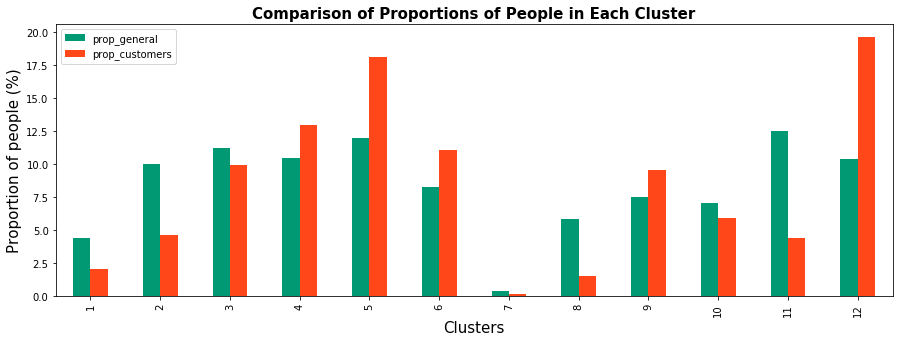

In [48]:
plot_proportions(general_predicted, customers_predicted)

In [96]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# add a column that maps clusters to data
customers_scaled.insert(loc = 0, column = 'cluster', value = customers_predicted)

# recode the clusters so they range from 1 to 12

customers_scaled['cluster'] = customers_scaled.apply(lambda x: x + 1)
customers_scaled['cluster'] = customers_scaled['cluster'].astype(np.int64)

In [109]:
# overrepresented cluster - 12

cluster12 = customers_scaled.loc[(customers_scaled['cluster'] == 12)]
cluster12.head(10)

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-0.191844,0.576267,0.981994,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,0.975635,-0.640433,-0.281855
6,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-0.191844,0.576267,0.981994,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,0.975635,-0.640433,1.212284
8,12,-0.701638,0.699743,-0.717376,-0.735063,0.707897,0.591425,-1.251766,1.340446,0.981994,...,-0.102089,4.210884,-0.853611,1.885221,-0.586105,-0.446411,-0.727148,0.975635,0.859741,1.212284
9,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-1.251766,0.576267,0.981994,...,-0.102089,-0.237480,-0.853611,1.885221,-0.586105,-0.446411,-0.727148,0.975635,-0.640433,0.465215
13,12,-0.701638,0.699743,-0.717376,0.503859,-0.501757,0.591425,0.868077,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,1.706179,-0.446411,-0.727148,0.975635,0.109654,1.212284
14,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-1.251766,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,1.706179,-0.446411,-0.727148,0.975635,-0.640433,1.212284
33,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-1.251766,1.340446,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,-0.586105,-0.446411,1.375237,0.975635,0.109654,0.465215
41,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,0.868077,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,1.885221,-0.586105,-0.446411,-0.727148,0.975635,0.109654,0.465215
46,12,-0.701638,0.699743,-0.717376,0.503859,-0.501757,0.591425,-1.251766,0.576267,0.981994,...,-0.102089,4.210884,-0.853611,-0.530442,1.706179,-0.446411,-0.727148,0.975635,0.859741,1.212284
47,12,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,0.868077,0.576267,0.981994,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,0.975635,0.109654,0.465215


In [111]:
cluster12.describe(include = 'all') 

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
count,25802.0,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,...,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000,25802.000000
mean,12.0,0.168384,0.486133,-0.669051,0.392653,-0.367346,0.530337,0.063914,0.505068,0.977188,...,-0.070635,-0.084040,0.402720,0.118366,-0.098188,-0.220055,0.168334,0.971293,-0.282193,0.422218
std,0.0,0.800936,0.639631,0.222780,0.369270,0.418922,0.271292,0.816146,0.497515,0.097939,...,0.557083,0.811810,0.982788,1.070698,0.938304,0.746251,1.039616,0.093104,0.750880,0.733224
min,12.0,-3.495279,-1.429096,-0.717376,-3.212907,-0.501757,-3.478759,-3.371609,-1.716268,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,-1.024973,-1.390521,-1.775993
25%,12.0,-0.701638,0.699743,-0.717376,0.503859,-0.501757,0.591425,-0.191844,0.576267,0.981994,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,0.975635,-0.640433,0.465215
50%,12.0,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,-0.191844,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,-0.586105,-0.446411,-0.727148,0.975635,-0.640433,0.465215
75%,12.0,0.695183,0.699743,-0.717376,0.503859,-0.501757,0.591425,0.868077,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,1.885221,-0.586105,-0.446411,1.375237,0.975635,0.109654,1.212284
max,12.0,0.695183,0.699743,1.263350,0.503859,1.917551,0.591425,0.868077,1.340446,0.981994,...,9.795344,4.210884,1.171494,1.885221,1.706179,2.240088,1.375237,0.975635,1.609829,1.212284


In [49]:
map_weights(customers_scaled, pca, 12) 

[('OST_WEST_KZ', 0.32792195833375126),
 ('KKK', 0.3064645086544735),
 ('SHOPPER_TYP_3.0', 0.25573384462361537),
 ('BALLRAUM', 0.17697480865641715),
 ('MIN_GEBAEUDEJAHR', 0.16103339297297081),
 ('CJT_GESAMTTYP_1.0', 0.15809212290581612),
 ('INNENSTADT', 0.15457384456154444),
 ('KBA05_ANTG3', 0.1347930913033768),
 ('SEMIO_LUST', 0.11961530119285299),
 ('CJT_GESAMTTYP_5.0', 0.10878069757413014),
 ('FINANZ_VORSORGER', 0.10865070715176013),
 ('FINANZTYP_6', 0.10490709057532507),
 ('SEMIO_VERT', 0.10397824176708283),
 ('GREEN_AVANTGARDE', 0.098468274618186455),
 ('PRAEGENDE_JUGENDJAHRE_avant', 0.098468274618186427),
 ('PLZ8_ANTG3', 0.092291091186356783),
 ('GEBAEUDETYP_RASTER', 0.084325586964947394),
 ('KBA05_ANTG2', 0.08378192667226958),
 ('ONLINE_AFFINITAET', 0.083000702095049644),
 ('ANZ_TITEL', 0.082190952621921207),
 ('CAMEO_INTL_2015_life_stage', 0.077828021270262046),
 ('FINANZTYP_4', 0.071793671145630719),
 ('SEMIO_KRIT', 0.071715381649192778),
 ('ANREDE_KZ', 0.06011392678886552),
 (

In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# underrepresented cluster - 2

cluster2 = customers_scaled.loc[(customers_scaled['cluster'] == 2)]
cluster2.head(10)

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
17,2,0.695183,-1.429096,1.263350,-0.735063,0.707897,-1.443667,-1.251766,-0.187911,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,-1.024973,0.859741,0.465215
53,2,-0.701638,-1.429096,1.263350,-0.735063,0.707897,-0.426121,-1.251766,0.576267,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,-1.024973,0.859741,-1.775993
68,2,0.695183,-1.429096,2.253713,-1.973985,1.917551,-2.461213,0.868077,-0.952090,-1.018336,...,-0.102089,-0.237480,1.171494,-0.530442,1.706179,-0.446411,-0.727148,-1.024973,0.859741,-0.281855
84,2,-3.495279,-1.429096,0.272987,0.503859,-0.501757,-0.426121,0.868077,-0.952090,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,-1.024973,0.109654,0.465215
94,2,-0.701638,0.699743,2.253713,-4.451828,1.917551,-3.478759,-3.371609,0.576267,0.981994,...,9.795344,-0.237480,-0.853611,-0.530442,1.706179,-0.446411,-0.727148,0.975635,2.359916,-0.281855
102,2,-0.701638,0.699743,1.263350,-1.973985,0.707897,-0.426121,0.868077,0.576267,0.981994,...,-0.102089,4.210884,-0.853611,-0.530442,1.706179,-0.446411,-0.727148,0.975635,0.859741,0.465215
103,2,0.695183,0.699743,0.272987,-0.735063,1.917551,-2.461213,-0.191844,0.576267,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,-0.586105,-0.446411,1.375237,0.975635,1.609829,-0.281855
127,2,-3.495279,0.699743,-0.717376,0.503859,-0.501757,0.591425,0.868077,0.576267,-1.018336,...,-0.102089,-0.237480,-0.853611,1.885221,-0.586105,-0.446411,-0.727148,-1.024973,0.859741,-0.281855
182,2,-0.701638,-1.429096,-0.717376,-0.735063,0.707897,-2.461213,-1.251766,1.340446,0.981994,...,-0.102089,4.210884,-0.853611,-0.530442,-0.586105,-0.446411,1.375237,0.975635,1.609829,0.465215
199,2,-0.701638,-1.429096,3.244075,-3.212907,3.127206,-2.461213,-3.371609,-0.187911,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,-0.586105,2.240088,-0.727148,0.975635,2.359916,0.465215


In [114]:
cluster2.describe(include = 'all') 

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
count,6045.0,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,...,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000,6045.000000
mean,2.0,-1.102314,-0.726174,0.628502,-1.347453,1.138530,-1.658791,-0.955268,0.493086,-0.077899,...,0.595397,0.638211,0.012042,-0.144815,0.035409,0.269989,-0.159904,-0.077456,1.281006,-0.000452
std,0.0,1.319648,1.001236,1.157701,1.303164,1.097356,1.248556,1.089494,0.923681,0.998463,...,2.533358,1.768919,1.001923,0.884854,1.019107,1.188113,0.933243,0.998993,0.736581,0.868011
min,2.0,-3.495279,-1.429096,-0.717376,-4.451828,-0.501757,-3.478759,-3.371609,-1.716268,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,-1.024973,-1.390521,-1.775993
25%,2.0,-2.098458,-1.429096,-0.717376,-1.973985,0.707897,-2.461213,-1.251766,-0.187911,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,-1.024973,0.859741,-0.281855
50%,2.0,-0.701638,-1.429096,0.272987,-0.735063,0.707897,-1.443667,-1.251766,0.576267,-1.018336,...,-0.102089,-0.237480,-0.853611,-0.530442,-0.586105,-0.446411,-0.727148,-1.024973,1.609829,0.465215
75%,2.0,-0.701638,0.699743,1.263350,-0.735063,1.917551,-0.426121,-0.191844,1.340446,0.981994,...,-0.102089,-0.237480,1.171494,-0.530442,1.706179,2.240088,1.375237,0.975635,1.609829,0.465215
max,2.0,0.695183,0.699743,3.244075,0.503859,4.336860,0.591425,0.868077,1.340446,0.981994,...,9.795344,4.210884,1.171494,1.885221,1.706179,2.240088,1.375237,0.975635,2.359916,1.212284


In [61]:
map_weights(customers_scaled, pca, 2)  

[('GREEN_AVANTGARDE', 0.3371347878747053),
 ('PRAEGENDE_JUGENDJAHRE_avant', 0.33713478787470519),
 ('EWDICHTE', 0.24902807815235953),
 ('ORTSGR_KLS9', 0.23514470693118009),
 ('HH_EINKOMMEN_SCORE', 0.21965891926416253),
 ('KKK', 0.20096670479340373),
 ('FINANZTYP_5', 0.18196691316379221),
 ('SEMIO_KAEM', 0.17236813089621131),
 ('ANZ_PERSONEN', 0.15717105165961831),
 ('FINANZ_ANLEGER', 0.15663662553411686),
 ('FINANZ_HAUSBAUER', 0.14939092524578335),
 ('ONLINE_AFFINITAET', 0.14770432061909899),
 ('LP_FAMILIE_GROB_5.0', 0.12267801240414171),
 ('ANREDE_KZ', 0.12255443476221145),
 ('W_KEIT_KIND_HH', 0.12138923757608427),
 ('PLZ8_ANTG2', 0.10776222657637674),
 ('PLZ8_ANTG3', 0.10247957712393002),
 ('RELAT_AB', 0.10145278626411038),
 ('PLZ8_HHZ', 0.099863973929707736),
 ('SEMIO_DOM', 0.090727807758818016),
 ('SEMIO_KRIT', 0.084964450571576339),
 ('PLZ8_ANTG4', 0.084488673012119556),
 ('FINANZTYP_3', 0.078934079896625681),
 ('GEBAEUDETYP_RASTER', 0.075989720805181682),
 ('LP_FAMILIE_GROB_4.0',

In [99]:
# code the missing group as cluster '-1' for the general and customers data

general - non missing
azdias_scaled.insert(loc = 0, column = 'cluster', value = general_predicted)
azdias_scaled['cluster'] = azdias_scaled.apply(lambda x: x + 1)
azdias_scaled['cluster'] = azdias_scaled['cluster'].astype(np.int64)

# general - missing
azdias_scaled_missing.insert(loc = 0, column = 'cluster', value = -1)
azdias_scaled_missing['cluster'] = azdias_scaled_missing['cluster'].astype(np.int64)

#customers
customers_scaled_missing.insert(loc = 0, column = 'cluster', value = -1)
customers_scaled_missing['cluster'] = customers_scaled_missing['cluster'].astype(np.int64)

In [101]:
azdias_scaled.head()

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,3,-1.745331,-0.967143,1.523882,-1.583638,1.052322,-1.515463,-1.033712,-1.341487,-0.540443,...,5.260360,-0.255083,-0.567459,-0.450691,-0.674970,-0.610610,1.861250,-0.540443,1.136311,-1.253076
1,4,0.199519,-0.967143,1.523882,-0.904906,1.773429,0.542974,-0.307958,-1.341487,1.850334,...,-0.190101,-0.255083,-0.567459,-0.450691,-0.674970,1.637708,-0.537273,1.850334,1.136311,0.756387
2,5,1.171944,-0.967143,-0.676124,0.452556,-1.110999,0.542974,1.143550,0.826192,-0.540443,...,-0.190101,-0.255083,-0.567459,-0.450691,1.481548,-0.610610,-0.537273,-0.540443,-0.228530,-0.583255
3,8,0.199519,1.033973,-0.676124,-0.226175,-0.389892,1.229119,-0.307958,0.826192,-0.540443,...,-0.190101,-0.255083,1.762240,-0.450691,-0.674970,1.637708,-0.537273,-0.540443,-0.228530,0.086566
4,5,-1.745331,-0.967143,0.057211,1.131288,-1.110999,0.542974,0.417796,-1.341487,-0.540443,...,-0.190101,-0.255083,-0.567459,2.218815,-0.674970,-0.610610,-0.537273,-0.540443,-1.593372,0.756387


In [102]:
azdias_scaled_missing.head()

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,-1,-0.660099,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
1,-1,-0.660099,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
2,-1,-1.781651,-0.910122,1.864546,-0.394190,0.144091,-0.631944,-0.647779,0.661183,3.918917,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,2.251069,3.918917,0.490603,1.028782
3,-1,0.461452,1.098753,0.052971,-0.394190,0.144091,-0.631944,-0.647779,-0.207873,-0.255173,...,-0.153148,-0.230962,-0.40535,-0.16014,-0.438042,-0.239474,-0.444233,-0.255173,0.490603,-0.570969
4,-1,1.583004,-0.910122,-0.852817,2.127028,-2.018699,2.331119,2.796787,-1.076929,-0.255173,...,-0.153148,-0.230962,-0.40535,-0.16014,2.282887,-0.239474,-0.444233,-0.255173,-2.218459,-0.570969


In [103]:
customers_scaled_missing.head()

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,-1,1.875042,0.966910,-2.473917,2.377442,-2.404106,2.480102,1.363762,1.290354,-0.228967,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,3.212964,-0.228967,0.208652,0.192283
1,-1,0.912957,-1.034223,-1.046921,1.430794,-1.002636,0.265612,1.363762,2.823340,-0.228967,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,3.212964,-0.228967,0.208652,0.192283
2,-1,-1.011213,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283
3,-1,0.912957,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283
4,-1,-0.049128,-1.034223,0.380074,-0.462502,0.398834,-0.472552,-0.459493,-0.242632,-0.228967,...,-0.063254,-0.156003,-0.318785,-0.129314,-0.272518,-0.167332,-0.311239,-0.228967,0.208652,0.192283


In [113]:
# add missing group as a cluster to the dataset 

general_combined = pd.concat([azdias_scaled, azdias_scaled_missing], ignore_index=True )
customers_combined = pd.concat([customers_scaled, customers_scaled_missing], ignore_index=True )

In [114]:
general_combined.head()

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,3,-1.745331,-0.967143,1.523882,-1.583638,1.052322,-1.515463,-1.033712,-1.341487,-0.540443,...,5.260360,-0.255083,-0.567459,-0.450691,-0.674970,-0.610610,1.861250,-0.540443,1.136311,-1.253076
1,4,0.199519,-0.967143,1.523882,-0.904906,1.773429,0.542974,-0.307958,-1.341487,1.850334,...,-0.190101,-0.255083,-0.567459,-0.450691,-0.674970,1.637708,-0.537273,1.850334,1.136311,0.756387
2,5,1.171944,-0.967143,-0.676124,0.452556,-1.110999,0.542974,1.143550,0.826192,-0.540443,...,-0.190101,-0.255083,-0.567459,-0.450691,1.481548,-0.610610,-0.537273,-0.540443,-0.228530,-0.583255
3,8,0.199519,1.033973,-0.676124,-0.226175,-0.389892,1.229119,-0.307958,0.826192,-0.540443,...,-0.190101,-0.255083,1.762240,-0.450691,-0.674970,1.637708,-0.537273,-0.540443,-0.228530,0.086566
4,5,-1.745331,-0.967143,0.057211,1.131288,-1.110999,0.542974,0.417796,-1.341487,-0.540443,...,-0.190101,-0.255083,-0.567459,2.218815,-0.674970,-0.610610,-0.537273,-0.540443,-1.593372,0.756387


In [115]:
customers_combined.head()

,cluster,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_avant,PRAEGENDE_JUGENDJAHRE_decades,CAMEO_INTL_2015_life_stage
0,2,0.694582,0.699692,-0.717629,0.501186,-0.499109,0.590449,-0.210551,0.584905,0.974525,...,-0.101607,-0.235139,-0.869077,-0.536744,-0.585325,-0.447377,1.385177,0.969037,-0.642505,-0.283602
1,12,0.694582,-1.429201,-0.717629,0.501186,-0.499109,0.590449,-2.352421,-0.945130,0.974525,...,-0.101607,-0.235139,-0.869077,-0.536744,1.708453,-0.447377,-0.721929,0.969037,-0.642505,0.463519
2,3,-0.707588,0.699692,1.264020,0.501186,0.716247,-2.470376,-3.423356,0.584905,-1.026141,...,-0.101607,-0.235139,1.150646,-0.536744,1.708453,-0.447377,-0.721929,-1.031953,0.864963,-1.777844
3,8,-0.707588,0.699692,-0.717629,0.501186,-0.499109,0.590449,-0.210551,-0.180113,0.974525,...,-0.101607,-0.235139,-0.869077,-0.536744,1.708453,-0.447377,-0.721929,0.969037,-0.642505,0.463519
4,2,0.694582,0.699692,-0.717629,0.501186,-0.499109,0.590449,0.860384,0.584905,0.974525,...,-0.101607,-0.235139,-0.869077,1.863087,-0.585325,-0.447377,-0.721929,0.969037,-0.642505,-0.283602


In [213]:
def plot_proportions2(df1, df2):
    
    # create a list for the general (azdias) and customers data
    prop_general_list = []
    prop_customers_list = []

    # loop through the cluster column 
    clusters = [-1,1,2,3,4,5,6,7,8,9,10,11,12]
    sum_general = list(df1['cluster'].value_counts())
    sum_customers = list(df2['cluster'].value_counts())
    
    for i in sum_general:
        prop_general = (i/len(df1)*100)
        prop_general_list.append(prop_general)
        
    for j in sum_customers:
        prop_customers = (j/len(df2)*100)    
        prop_customers_list.append(prop_customers)
            
    df_combined = pd.DataFrame({'clusters' : clusters, 'prop_general' : prop_general_list, 
                                'prop_customers': prop_customers_list})

    df_combined.plot(x = 'clusters' , y = ['prop_general', 'prop_customers'], kind = 'bar', 
                     color = ['#009973', '#ff471a'], figsize=(15, 5))
    plt.title('Comparison of Proportions of People in Each Cluster', fontsize = 15, fontweight = 'bold') 
    plt.ylabel('Proportion of people (%)', fontsize = 15)
    plt.xlabel('Clusters', fontsize = 15)
    
    plt.show()

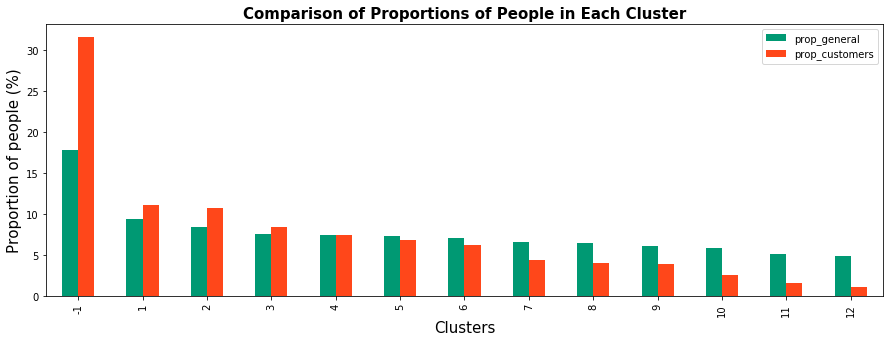

In [207]:
plot_proportions2(general_combined, customers_combined)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The results showed that there were overrepresented or underrepresented clusters in the customers dataset. The cluster that was most overrepresented was Cluster 12 (n = 25,802). These people were more likely to live in East germany and far from the city. They tended to be demaing shoppers with high purchasing power, enthusiastic about product advertising focusing on one or two buying channels such as mail orders. They were less likely to save money, be rational, nor accept risks. There were also some indications that these people live in areas that were not densely populated. These characteritics may describe impulse buyers living outside the city who could be target customers of the mail-order company. 

An example of underreprsented cluster is Cluster 2 (n = 6,045). People who live in a large urban community, earn higher income, and avantgarde trends were grouped in this cluster. They may live in close proximity to shopping locations such as deparment stores or malls and have more sofisticated taste for products and thus have less needs to do mail orders. Efforts to market products to this segement of general population may prove to be unproductive.

A large percentage of people were removed from the data analysis when they had more than 10% of values missing. When the data of these people were added back to the dataset and plotted, the proportion of missing data group was larger for the customers dataset (32%) than the general population dataset (18%). After accounting for their proporations in the dataset, the differences between the general and customer datasets were much smaller than without them in each cluster. This further justifies the decision that the people in the missing data group should be analyzed separately to examine thier trends and purchase behavior to make an informed marketing decision.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.